# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Asia FX
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="friday",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

In [36]:
fwd = ['EUR1M CMPN Curncy', 'GBP1M CMPN Curncy', 'AUD1M CMPN Curncy', 
       'NZD1M CMPN Curncy', 'JPY1M CMPN Curncy', 'CAD1M CMPN Curncy', 
       'SEK1M CMPN Curncy', 'NOK1M CMPN Curncy', 'CHF1M CMPN Curncy']

fwd_scale_g10 = {"EURUSD": 10000,
             "GBPUSD" : 10000,
             "AUDUSD" : 10000,
             "NZDUSD" : 10000,
             "USDJPY" : 100,
             "USDCAD" : 10000,
             "USDSEK" : 10000,
             "USDNOK" : 10000,
             "USDCHF" : 10000}

fwd_data = new_raw_data[fwd].pipe(fill_date, fill_forward=True)
fwd_data.columns = fwd_scale_g10.keys()
for c in fwd_scale_g10.keys():
  fwd_data[c] = fwd_data[c]/fwd_scale_g10[c]
  
fwd_price_ori = spot_price_ori[fwd_scale_g10.keys()] + fwd_data

In [37]:
bp_usd = np.log10(fwd_price_ori.pipe(standardize_series, "prices")) - np.log10(spot_price_ori[fwd_scale_g10.keys()].pipe(standardize_series, "prices"))

In [38]:
def custom_skew(series, window):
  num = (series - series.rolling(window).mean())**3
  denom = series.rolling(window).std(ddof=0)**3
  return (num/denom).rolling(window).mean()

In [45]:
sig = bp_usd.ffill().pipe(custom_skew, 21*3).pipe(cap_helper, 10).pipe(rolling_mean, 5) * -1

# Signal

In [46]:
b = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [47]:
bt_obj = b

In [48]:
get_summary(bt_obj)

Returns   : 0.06716806049522217
Vol       : 0.11527320003968355
SR        : 0.5826858321977626
Max DD    : -30.51
Hit rate  : 0.518
W | N | L : 0.52 | 0.0 | 0.48
W/L Ratio : 1.07


In [49]:
get_returns_stats(bt_obj.asset_rtn.loc["2003":], b.wts.loc["2003":])

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.289493,0.560584,1.68723,1.055692,1.494769,0.098088,1.189523,0.219447,0.081222
sharpe,0.164729,0.298812,0.590958,0.400176,0.519119,0.057335,0.48014,0.114483,0.016711
dollar_sharpe,0.150983,0.279274,0.600199,0.391168,0.518369,0.047952,0.485379,0.106859,-0.008548
trade_sharpe,0.164729,0.298812,0.590958,0.400176,0.519119,0.057335,0.48014,0.114483,0.016711
long_sharpe,-0.318849,-0.147949,0.672293,0.37786,0.649807,-0.368135,0.424288,0.014505,-0.079105
short_sharpe,0.651167,0.848203,0.422766,0.425536,0.087542,0.342006,0.712288,0.322382,0.530903
sortino,0.100414,0.186337,0.398085,0.263974,0.343592,0.034658,0.294092,0.071623,0.006725
max_drawdown,-6.339297,-7.106425,-7.220011,-7.12516,-7.952142,-6.826849,-6.74752,-7.981211,-15.05207
max_drawdown_start,2004-02-17,2004-05-17,2010-06-07,2009-11-16,2008-03-17,2014-07-09,2004-04-21,2003-08-26,2015-01-13
max_drawdown_end,2007-08-16,2006-04-03,2013-02-01,2013-01-02,2011-10-28,2016-09-07,2004-12-03,2004-12-03,2015-01-15


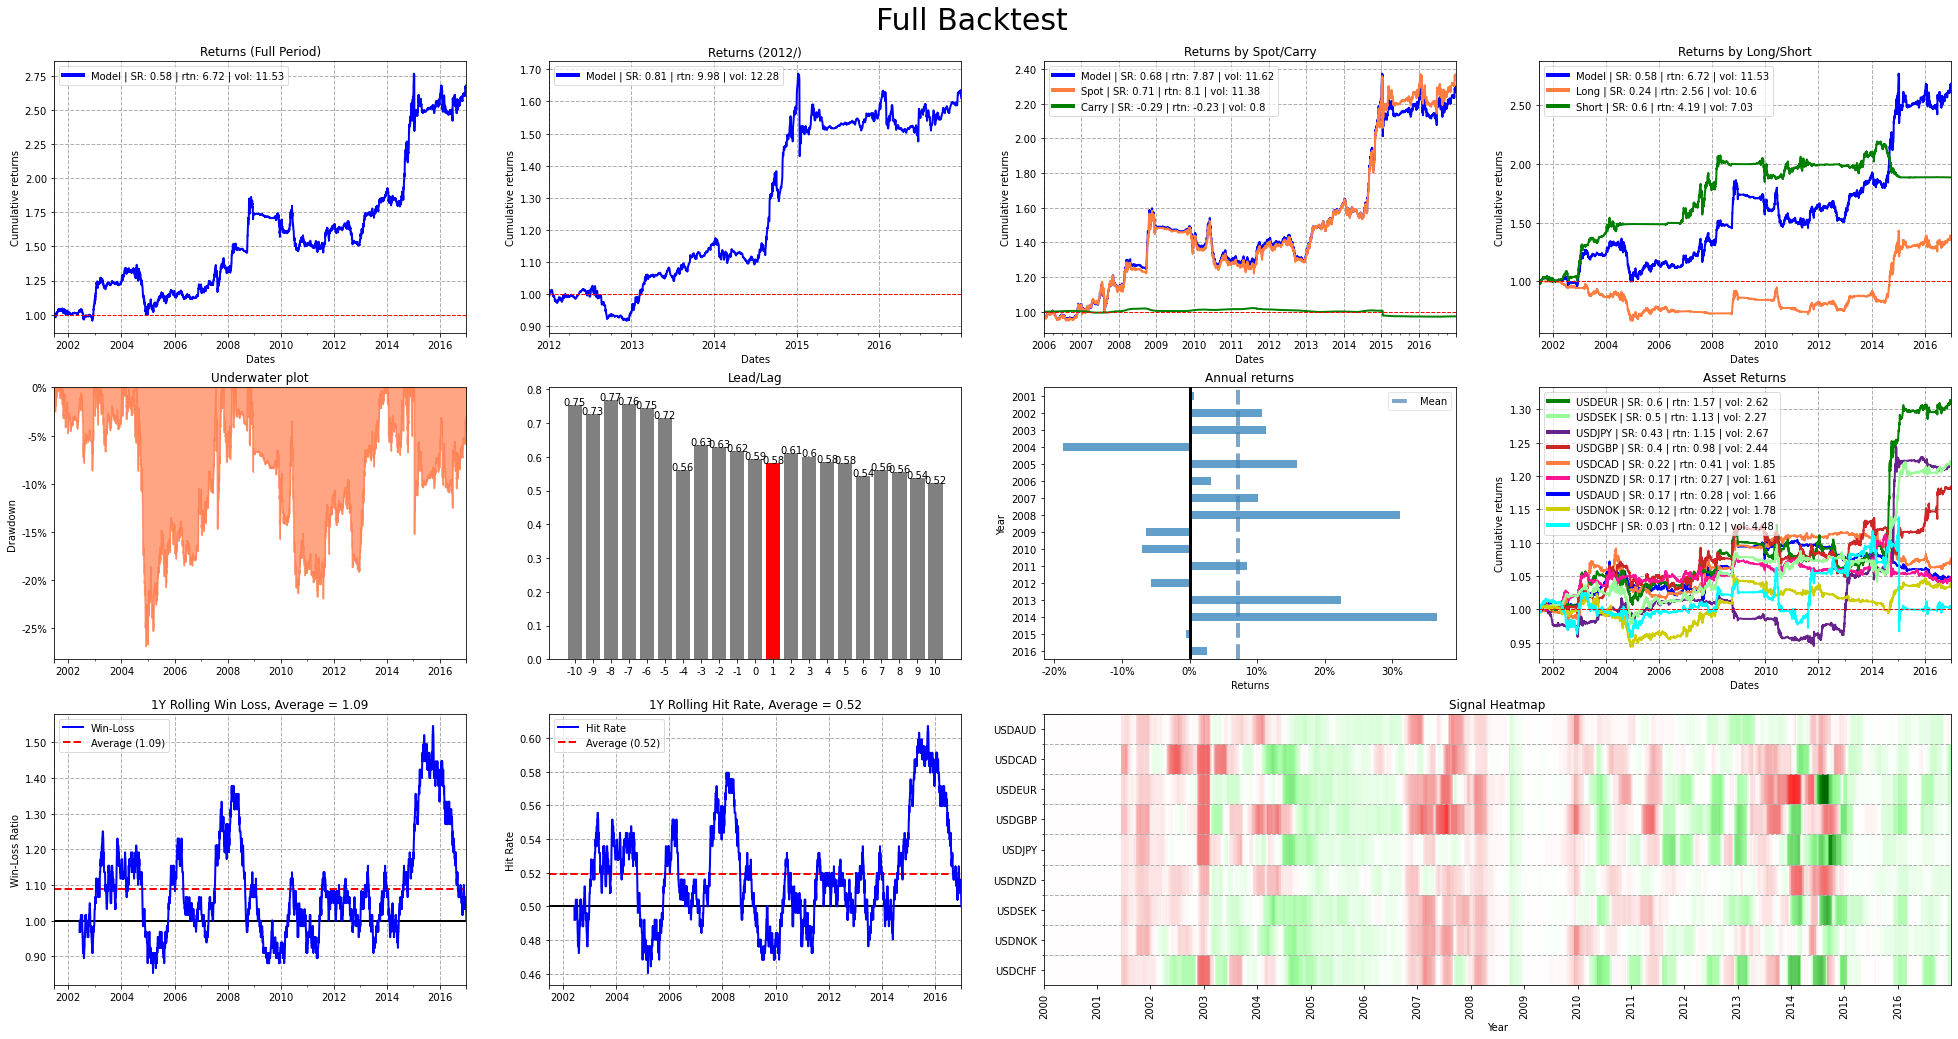

In [50]:
plot_bt(bt_obj)

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

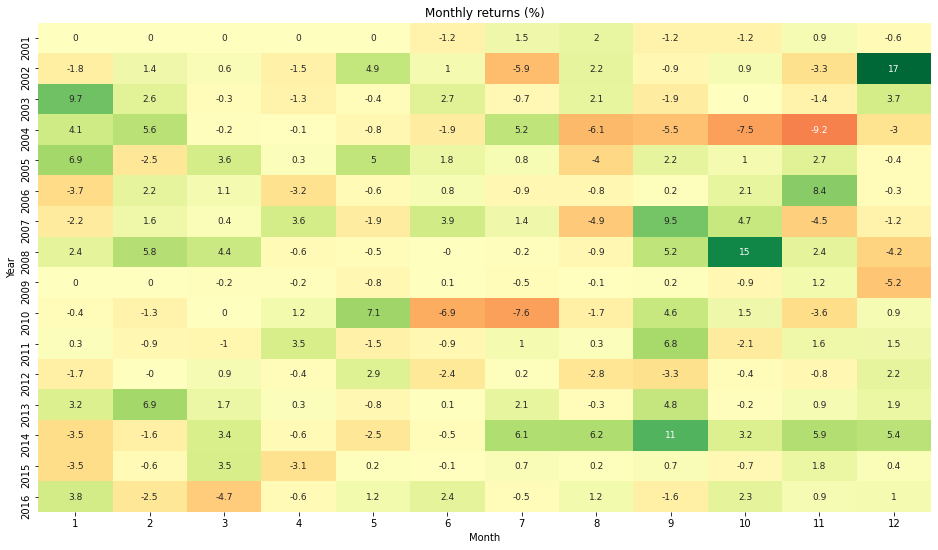

In [13]:
pf.plot_monthly_returns_heatmap(bt_obj.model_rtn)

<AxesSubplot:title={'center':'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

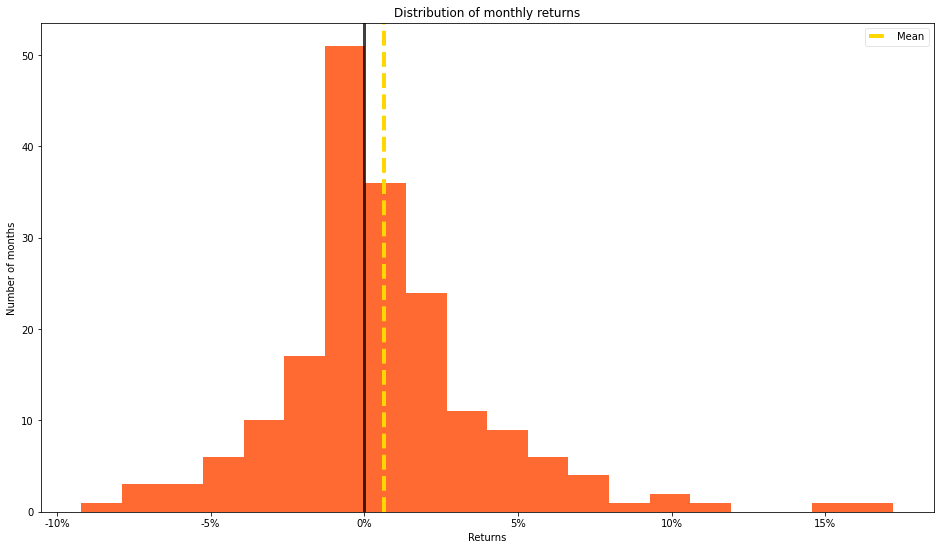

In [14]:
pf.plot_monthly_returns_dist(bt_obj.model_rtn)